In [33]:
pip install pyaudio

Note: you may need to restart the kernel to use updated packages.


In [34]:
pip install matplotlib numpy

Note: you may need to restart the kernel to use updated packages.


In [35]:
import pyaudio
import wave
import sys
import time
import math
import matplotlib.pyplot as plt
import numpy as np
import wave


In [36]:
FORMAT = pyaudio.paInt16
CHANNELS = 1  
RATE = 44100 if sys.platform == 'darwin' else 16000  
CHUNK = 1024  # Buffer size for audio chunks

In [37]:
# Initialize PyAudio and start the stream
def start_audio_stream():
    audio = pyaudio.PyAudio()
    stream = audio.open(format=FORMAT, channels=CHANNELS,
                        rate=RATE, input=True,
                        frames_per_buffer=CHUNK)
    return audio, stream

In [38]:

def compute_energy(data):
    energy=10*math.log(sum(sample**2 for sample in data))
    return energy

In [39]:


def classifyFrame(audioframe,level,background):
    forgetfactor=2
    adjustment=0.05
    threshold=20
    
    

    current = compute_energy(audioframe)
    print(f'current: {current}')
    isSpeech = False
    level = ((level * forgetfactor) + current) / (forgetfactor + 1)
    
    if (current < background):
        background = current
    else:
        background += (current - background) * adjustment
    print(f'level: {level}')
    print(f'background: {background}')
    if (level < background):
        level = background
        
    if (level - background > threshold):
        
        isSpeech = True
    print(f'level1: {level}')
    print(f'background1: {background}')
    print(isSpeech)
    return isSpeech,level,background


In [40]:
# Capture audio until silence is detected
import struct

def capture_audio(stream):
    print("Hit Enter to start recording")
    input()
    print("Recording in progress...")
    frames = []
    
    silence_threshold = 200  # ambient noise
    silence_duration = 1 # Duration of silence in seconds to stop recording
    silence_time = 0
    count=0
    sum=0
    level=0
    background=0
    isRecording=True
    NoSpeechAfterSpeech=False
    while isRecording:
        data = stream.read(CHUNK, exception_on_overflow=False)
        #frames.append(data)
        data_fl = [struct.unpack('h', data[i:i+2])[0] for i in range(0, len(data), 2)]
        if count==0:   
            level=compute_energy(data_fl)
        if count<=9:
            sum=sum+compute_energy(data_fl)
            count=count+1
        if count==10:
            background=sum//10
            count=count+1
            print(f'background0: {background}')
        if count>10:
            isSpeech,level,background=classifyFrame(data_fl,level,background)
            #print(f'level: {level}')
            #print(f'background: {background}')
            #print(f'isSpeech{isSpeech}')
            print(f'background0: {background}')
            
            if isSpeech:
                frames.append(data)
                silent_chunks = 0 
                NoSpeechAfterSpeech=True 
                silent_chunks=0# reset the silent_chunks counter as we've detected speech
            else:
                if isRecording:
                    if NoSpeechAfterSpeech:
                        frames.append(data)
            # If we've started recording and encounter silence, increment the counter
                        silent_chunks += 1
                        print(silent_chunks)
                    #print(silent_chunks)
            # If we've hit the silence threshold, consider it the end of speech
                        if silent_chunks > 40:
                            isRecording=False
        
    return frames

In [41]:
# Save captured audio to a file
def save_audio(frames, filename):
    wave_file = wave.open(filename, 'wb')
    wave_file.setnchannels(CHANNELS)
    wave_file.setsampwidth(pyaudio.get_sample_size(FORMAT))
    wave_file.setframerate(RATE)
    wave_file.writeframes(b''.join(frames))
    wave_file.close()

In [42]:
# Handle the audio capture process
def main():
    audio, stream = start_audio_stream()
    frames = capture_audio(stream)

    # Stop and close the stream
    stream.stop_stream()
    stream.close()
    audio.terminate()

    # Save the recorded frames as a WAV file
    filename = 'captured_speech.wav'
    save_audio(frames, filename)
    print(f"Recording stopped and saved to '{filename}'")

if __name__ == '__main__':
    main()
    

Hit Enter to start recording


Recording in progress...
background0: 133.0
current: 161.85601670962572
level: 138.56401873812453
background: 134.44280083548128
level1: 138.56401873812453
background1: 134.44280083548128
False
background0: 134.44280083548128
current: 146.2344428920033
level: 141.12082678941746
background: 135.0323829383074
level1: 141.12082678941746
background1: 135.0323829383074
False
background0: 135.0323829383074
current: 138.8188894800455
level: 140.35351435296013
background: 135.22170826539428
level1: 140.35351435296013
background1: 135.22170826539428
False
background0: 135.22170826539428
current: 138.19855106730125
level: 139.6351932577405
background: 135.37055040548964
level1: 139.6351932577405
background1: 135.37055040548964
False
background0: 135.37055040548964
current: 146.76365109749244
level: 142.01134587099114
background: 135.94020544008978
level1: 142.01134587099114
background1: 135.94020544008978
False
background0: 135.94020544008978
current: 140.92598965167684
level: 141.64956046455305

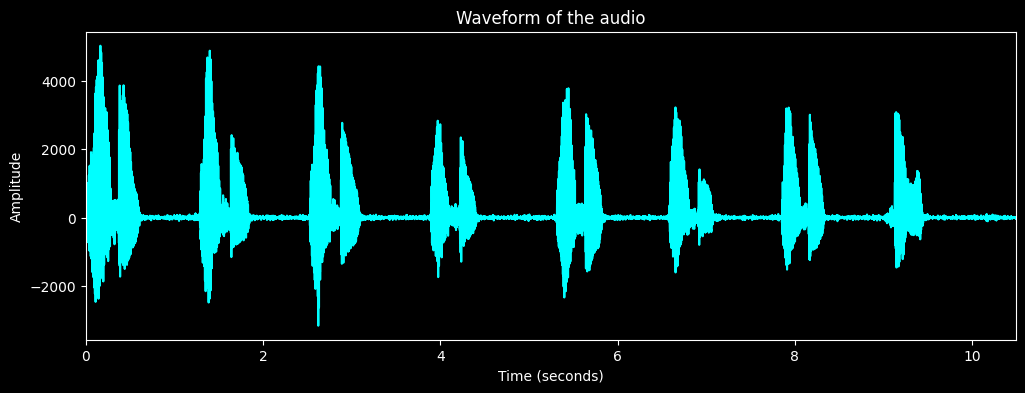

In [43]:


def plot_waveform(filename):
    
    
    with wave.open(filename, 'rb') as wave_file:
        # Extract Raw Audio 
        signal = wave_file.readframes(-1)
        # Convert binary data to integers
        signal = np.frombuffer(signal, dtype='int16')
        
        # Get the frame rate
        framerate = wave_file.getframerate()
        
        # Time axis in seconds
        time = np.linspace(0, len(signal) / framerate, num=len(signal))

        plt.style.use('dark_background')  # Set the background theme
        
        # Plotting the waveform
        plt.figure(figsize=(12, 4))
        plt.plot(time, signal, color='cyan')
        plt.title('Waveform of the audio')
        plt.ylabel('Amplitude')
        plt.xlabel('Time (seconds)')
        plt.xlim(left=time[0], right=time[-1])
        plt.show()

plot_waveform('captured_speech.wav')
